In [ ]:
!pip install scalecast --upgrade

In [ ]:
# import packages
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scalecast.Forecaster import Forecaster
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0  59170      0 --:--:-- --:--:-- --:--:-- 59170
OK
34 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.9_amd64.deb ...
Unpacking gcsfuse (0.41.9) ...
Setting up gcsfuse (0.41.9) ...


In [ ]:
!mkdir googleBucketFolder
!gcsfuse --implicit-dirs colab-connect-bucket googleBucketFolder

2022/12/11 11:57:06.708103 Start gcsfuse/0.41.9 (Go version go1.18.4) for app "" using mount point: /content/googleBucketFolder
2022/12/11 11:57:06.750103 Opening GCS connection...
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithConn: fs.NewServer: create file system: SetUpBucket: OpenBucket: Unknown bucket "colab-connect-bucket": no such file or directory


In [ ]:
project_id = 'storied-toolbox-344322'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://sensor-dataset1/


In [ ]:
bucket_name = 'sensor-dataset1'

!gsutil -m cp -r /content/drive/MyDrive/sensor-data* gs://{bucket_name}/

Copying file:///content/drive/MyDrive/sensor-data/data_pm2_5.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///content/drive/MyDrive/sensor-data/sensor_data.csv [Content-Type=text/csv]...
\
Operation completed over 2 objects/1.3 GiB.                                      


In [ ]:
#import dataset
data_pm2_5 = pd.read_csv('/content/drive/MyDrive/sensor data/data_pm2_5.csv')
# filter to work with riruta data
riruta = data_pm2_5.loc[data_pm2_5['location'] == 'riruta']
#drop irrelevant columns
riruta_data = riruta.drop(['sensor_type', 'sensor_id', 'location', 'lat', 'lon', 'value_type', 'day', 'time', 'hour', 'quality', 'PM2.5_SubIndex'], axis = 1)
# cut shape
# riruta_data = riruta_data.iloc[:5000]

In [ ]:
#check data info
riruta_data.describe()

In [ ]:
# set datetime as index
riruta_data['timestamp'] = pd.to_datetime(riruta_data['timestamp'])
riruta_data = riruta_data.set_index(pd.DatetimeIndex(riruta_data['timestamp']))

In [ ]:
# resample and set freq
riruta_data = riruta_data.resample('5T').nearest()
riruta_data = riruta_data.asfreq('5T')
riruta_data.index.freq = '5T'
riruta_data.index=riruta_data.index.dropna()
print('index null', riruta_data.index.isna().sum())
print('values null', riruta_data['value'].isnull().sum())

index null 0
values null 0


In [ ]:
riruta_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112449 entries, 2021-11-01 00:00:00 to 2022-11-26 10:40:00
Freq: 5T
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  112449 non-null  datetime64[ns]
 1   value      112449 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 MB


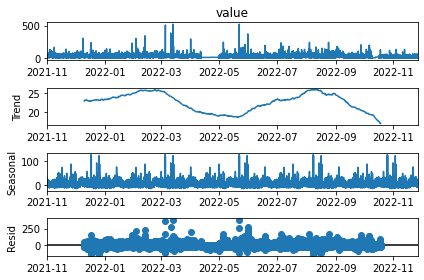

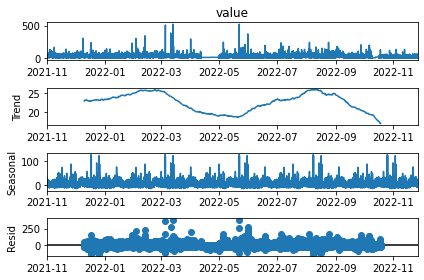

In [ ]:
# check for stationary
results = seasonal_decompose(riruta_data['value'], period=22489)
results.plot()

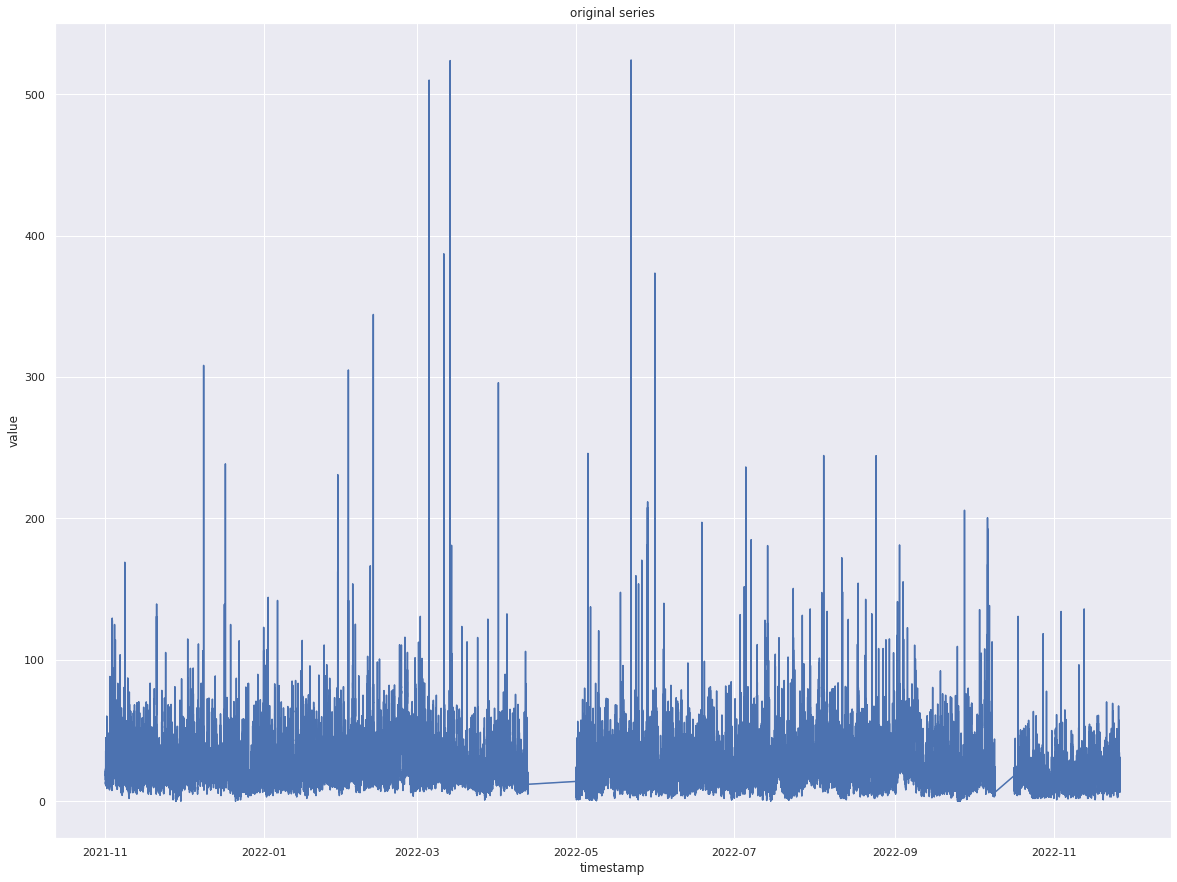

In [ ]:
# convert to stationary
# Original Series
plot01 = sns.lineplot(data=riruta_data, x='timestamp', y='value').set_title('original series')
sns.set(rc={'figure.figsize':(30,20)})

In [ ]:
# 1st Differencing
diff_data['value'] = riruta_data.value.diff()
plot02 = sns.lineplot(data=diff_data, x='timestamp', y='value').set_title('differenced series')
sns.set(rc={'figure.figsize':(30,20)})

In [ ]:
#cut riruta shape
riruta_data = riruta_data.iloc[:5000]

In [ ]:
# use split test and train
from sklearn.model_selection import train_test_split

train, test = train_test_split(riruta_data, test_size=0.3)

In [ ]:
train.shape

(3500, 2)

In [ ]:
# perform minmax scaler
scaled_train = scaler.fit_transform(train[['value']])
scaled_test = scaler.fit_transform(test[['value']])

In [ ]:
#define generator
n_input = 1000
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size =1)

In [ ]:
# create model
model1 = Sequential()
model1.add(LSTM(50,
                activation = 'relu',
                input_shape =(n_input, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam',
               loss = 'mse')

In [ ]:
#model summary
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model1.fit(generator, epochs = 1)

2500/2500 [==============================] - 661s 264ms/step - loss: 0.0069


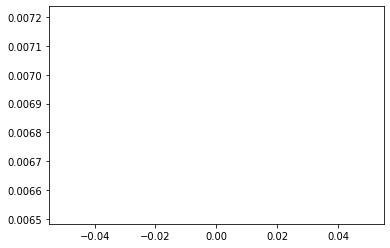

In [ ]:
# plot loss
loss= model1.history.history['loss']
plt.plot(range(len(loss)), loss)

In [ ]:
last_train_batch = scaled_train[2500:]
last_train_batch = last_train_batch.reshape(1, n_input,n_features)

In [ ]:
#predict
model1.predict(last_train_batch)

1/1 [==============================] - 0s 50ms/step


array([[0.12274909]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.26332574])

In [ ]:
test_predictions = []
first_batch = scaled_train[2500:]
current_batch = first_batch.reshape(1, n_input, n_features)

for i in range(len(test)):
  #get prediction for first batch
  current_pred = model1.predict(current_batch)[0]
  # append the prediction to the array
  test_predictions.append(current_pred)
  #use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 48ms/step


In [ ]:
test_predictions

[array([0.12274909], dtype=float32),
 array([0.12316225], dtype=float32),
 array([0.12350269], dtype=float32),
 array([0.1237794], dtype=float32),
 array([0.12399955], dtype=float32),
 array([0.12417198], dtype=float32),
 array([0.12430549], dtype=float32),
 array([0.12440799], dtype=float32),
 array([0.12448617], dtype=float32),
 array([0.12454549], dtype=float32),
 array([0.12459034], dtype=float32),
 array([0.12462418], dtype=float32),
 array([0.12464963], dtype=float32),
 array([0.12466878], dtype=float32),
 array([0.12468316], dtype=float32),
 array([0.12469397], dtype=float32),
 array([0.12470209], dtype=float32),
 array([0.1247082], dtype=float32),
 array([0.12471281], dtype=float32),
 array([0.1247163], dtype=float32),
 array([0.12471892], dtype=float32),
 array([0.12472092], dtype=float32),
 array([0.12472244], dtype=float32),
 array([0.12472359], dtype=float32),
 array([0.12472448], dtype=float32),
 array([0.12472515], dtype=float32),
 array([0.12472568], dtype=float32),
 arr

In [ ]:
test.head()

,timestamp,value
timestamp,,
2021-11-17 07:30:00,2021-11-17 07:29:39.285893,33.4
2021-11-04 23:20:00,2021-11-04 23:21:10.685357,13.2
2021-11-17 17:45:00,2021-11-17 17:44:31.673226,41.6
2021-11-17 11:55:00,2021-11-17 11:53:47.723298,11.0
2021-11-13 20:05:00,2021-11-13 20:04:27.001044,31.0


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['predictions'] = true_predictions

In [ ]:
# visualize prediction
test.plot()

In [ ]:
# evaluate model
from keras.metrics.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['value'], test['predictions']))
print(rmse)

14.376002918229357


In [ ]:
# save model

In [ ]:
# eda
f = Forecaster(y=riruta['value'],
                   current_dates=riruta['timestamp'])

In [ ]:
# build model
f.set_test_length(2000)       # 1. 12 observations to test the results
f.generate_future_dates(2000) # 2. 12 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

157/157 [==============================] - 0s 2ms/step


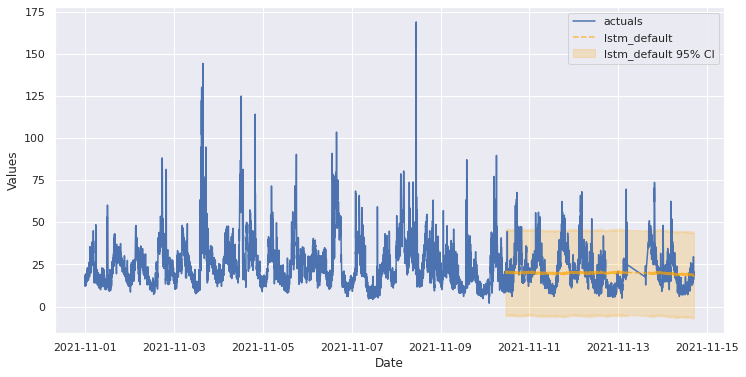

In [ ]:
# forecast
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

Epoch 1/50
10/10 [==============================] - 4s 183ms/step - loss: 0.1438 - val_loss: 0.1382
Epoch 2/50
10/10 [==============================] - 1s 140ms/step - loss: 0.1290 - val_loss: 0.1162
Epoch 3/50
10/10 [==============================] - 1s 139ms/step - loss: 0.0942 - val_loss: 0.0642
Epoch 4/50
10/10 [==============================] - 1s 140ms/step - loss: 0.0721 - val_loss: 0.0672
Epoch 5/50
10/10 [==============================] - 1s 140ms/step - loss: 0.0683 - val_loss: 0.0610
Epoch 6/50
10/10 [==============================] - 1s 138ms/step - loss: 0.0660 - val_loss: 0.0598
Epoch 7/50
10/10 [==============================] - 1s 137ms/step - loss: 0.0656 - val_loss: 0.0603
Epoch 8/50
10/10 [==============================] - 1s 139ms/step - loss: 0.0654 - val_loss: 0.0601
Epoch 9/50
10/10 [==============================] - 1s 141ms/step - loss: 0.0653 - val_loss: 0.0597
Epoch 10/50
10/10 [==============================] - 1s 141ms/step - loss: 0.0652 - val_loss: 0.0598

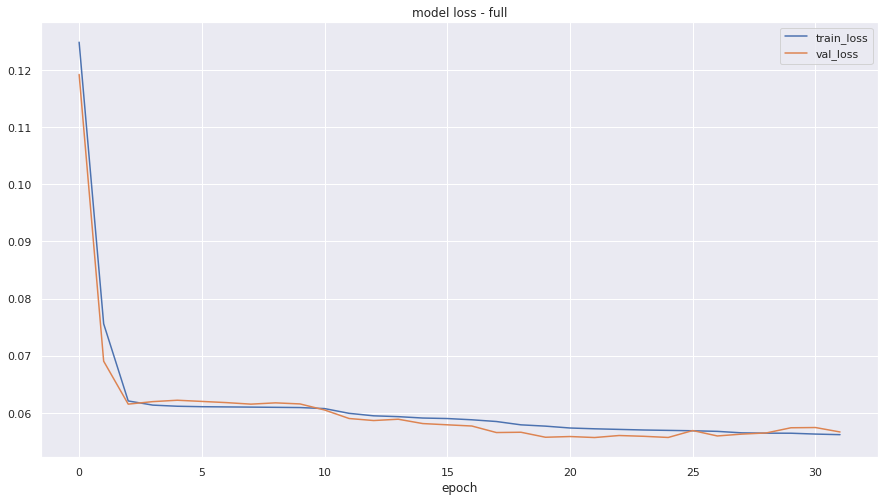

155/155 [==============================] - 2s 15ms/step


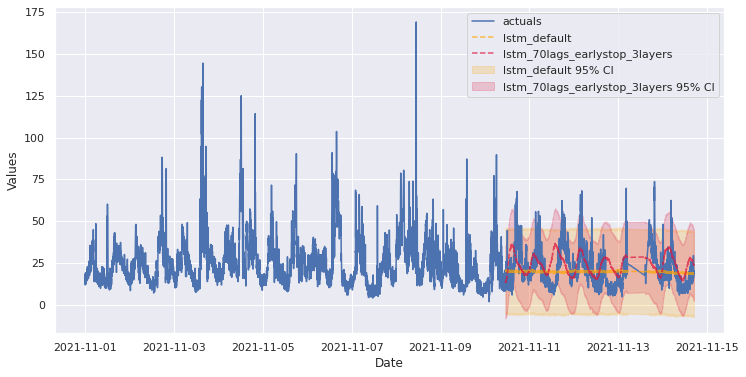

In [ ]:
# early stopping to increase number of layers
f.manual_forecast(call_me='lstm_70lags_earlystop_3layers',
                  lags=70,
                  batch_size = 256,
                  epochs=50,
                  validation_split=.2,
                  shuffle=True,
                  activation='relu',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=10),
                  lstm_layer_sizes=(30,30),
                  dropout=(0.2,0.2),
                  plot_loss = True)
f.plot_test_set(ci=True)

In [ ]:
# Generate LSTM network
model = tf.keras.Sequential()
lookback = 500
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)

In [ ]:
# define model
lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

In [ ]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

In [ ]:
# save model    
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'